# Eliiza Hamlet Challenge

<div style="text-align: right"> Yunxue Hu (Loretta)</div>
<div style="text-align: right"> 27/09/2019 </div>


## Challenge

1. Show the number of lines said per character throughout the play.

2. Make a word cloud of unusual words in the script

3. Compute the sentiment score for each scene.

In [1]:
#import some ensential libraries
import matplotlib.pyplot as plt
import re
from collections import Counter
import numpy as np


## 1. preprocessing

1.1 Load the whole file into a list

In [2]:
lineList = []
with open('hamlet.txt','r') as file:
    for line in file:
        line = line.strip('\n')
        if line == '':
            continue
        lineList.append(line.split('\t'))


1.2 KEYWORD 'SCENE ?' and 'ACT ?': they indicates where a scene starts and ends

In [3]:
content = {}
currentAct = ''
currentScene = ''
for i,l in enumerate(lineList):
    if 'SCENE' in l[0]:
        currentScene = l[0]
        content[(currentAct,currentScene)] = [i+1]
        # where a scene starts
    if 'ACT' in l[0]:
        content[(currentAct,currentScene)].append(i-1)
        # where a scene ends, record it first then update currentAct
        currentAct = l[0]
    if i == len(lineList)-1:
        content[(currentAct,currentScene)].append(i-1)
        # the last scene ends

In [4]:
content['ACT I','SCENE I']
#  take a look at this dictionary,'ACT I, SCENE I' starts from line 46 to line 244

[46, 244]

In [5]:
def removeAction(sentence):
    """
    remove stage directions, which are inside '[]'
    """
    return re.sub("[\[].*?[\]]", "", sentence)

def normalizeName(sentence):
    """
    get rid of punctuations
    """
    return re.sub("[^\w]", "", sentence)


def readOneScene(lineList,firstLine,lastLine):
    """
    set an offset to read script partially 
    
    Parameters: 
    lineList (int): script for the whole play
    firstLine: the index to indicate where starts 
    lastLine: the index to indicate where ends
  
    Returns: 
    currentScene: a list contains character name and their lines. 
    """
    currentScene = []

    currentLine = ''
    currentCharacter = ''
    for l in lineList[firstLine:lastLine+1]:
        if l[0] != '':
            if currentCharacter == '':
                currentCharacter = l[0]
                currentLine = removeAction(l[1])
            elif l[0] != currentCharacter:
                currentScene.append([currentCharacter,currentLine])
                currentCharacter = l[0]
                currentLine = removeAction(l[1])
                
        else:
            currentLine = removeAction(' '.join([currentLine,l[1]]))
    return currentScene

Now since we have a content table, it's easy to read script scene by scene

Be aware:
    1. Iterate all lines to read content info -> O(n)
    2. Iterate again to read lines -> O(n)

Even though the time complexity remains O(n), it increases the **computation complexity**

If the corpus is large, this method is discouraged, we can get things done within one iteration

 

In [6]:
playScript = {}
for playName, lines in content.items():
    playScript[playName] = readOneScene(lineList,lines[0],lines[1])

In [7]:
playScript['ACT I','SCENE I'][:5]
# show the first 5 lines of this scene

[['BERNARDO', "Who's there?"],
 ['FRANCISCO', 'Nay, answer me: stand, and unfold yourself.'],
 ['BERNARDO', 'Long live the king!'],
 ['FRANCISCO', 'Bernardo?'],
 ['BERNARDO', 'He.']]

## Challenge 1: Show the number of lines said per character throughout the play.

In [8]:
line_per_char = Counter()
for scene in playScript.values():
    for line in scene:
        line_per_char[normalizeName(line[0])] += 1

In [9]:
mostLineChar = line_per_char.most_common()
mostLineChar[:5]

[('HAMLET', 258),
 ('LORDPOLONIUS', 85),
 ('KINGCLAUDIUS', 81),
 ('HORATIO', 78),
 ('QUEENGERTRUDE', 60)]

<IPython.core.display.Javascript object>


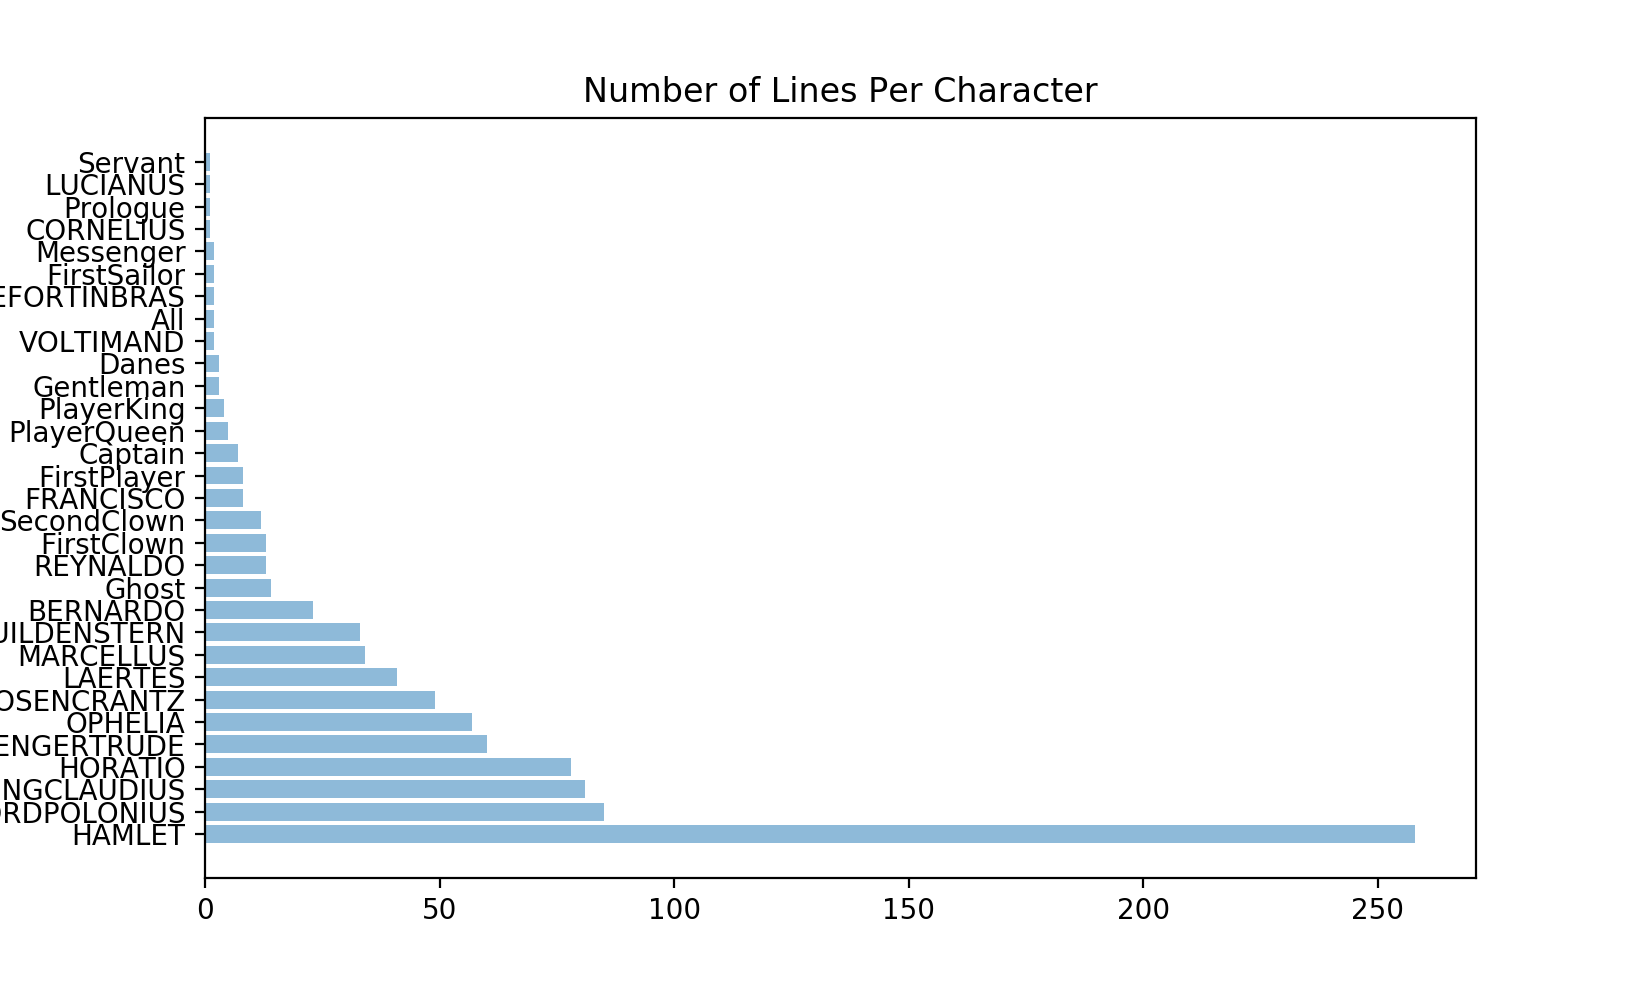

In [12]:
%matplotlib notebook

fig = plt.figure(0)
names = [x for x,y in mostLineChar]
y_pos = np.arange(len(names))
numLines = [y for x,y in mostLineChar]

plt.barh(y_pos, numLines, align='center', alpha=0.5)
plt.yticks(y_pos, names)
plt.title('Number of Lines Per Character')

plt.show()

## Challenge 2: Make a word cloud of unusual words in the script

In [13]:
corpus = ''
for scene in playScript.values():
    for line in scene:
        corpus = ' '.join([corpus, line[1]])

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/loretta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/loretta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
def lemmatize(word):
    """
    lemmatize words accordingly 
    """
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma

  
stop_words = set(stopwords.words('english')) 

tokenizer = RegexpTokenizer(r'\w+')
word_tokens = tokenizer.tokenize(corpus) 
  
filtered_sentence = [w.lower() for w in word_tokens] 
filtered_sentence = [w for w in filtered_sentence if not w in stop_words]
filtered_sentence = [lemmatize(w) for w in filtered_sentence]  

The whole corpus is tokenized and cleaned.

Now we can use Counter to count the frequency of each word

In order to get the **unusual words**, we can simply make it **divided by 1**. 

In [16]:
freq_word = Counter()
for word in filtered_sentence:
    freq_word[word] += 1
    
unusual_words = Counter({w: 1/f for w, f in freq_word.items()})

In [17]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=900,max_font_size=50, 
                      max_words=100, background_color="white").generate_from_frequencies(unusual_words)

<IPython.core.display.Javascript object>


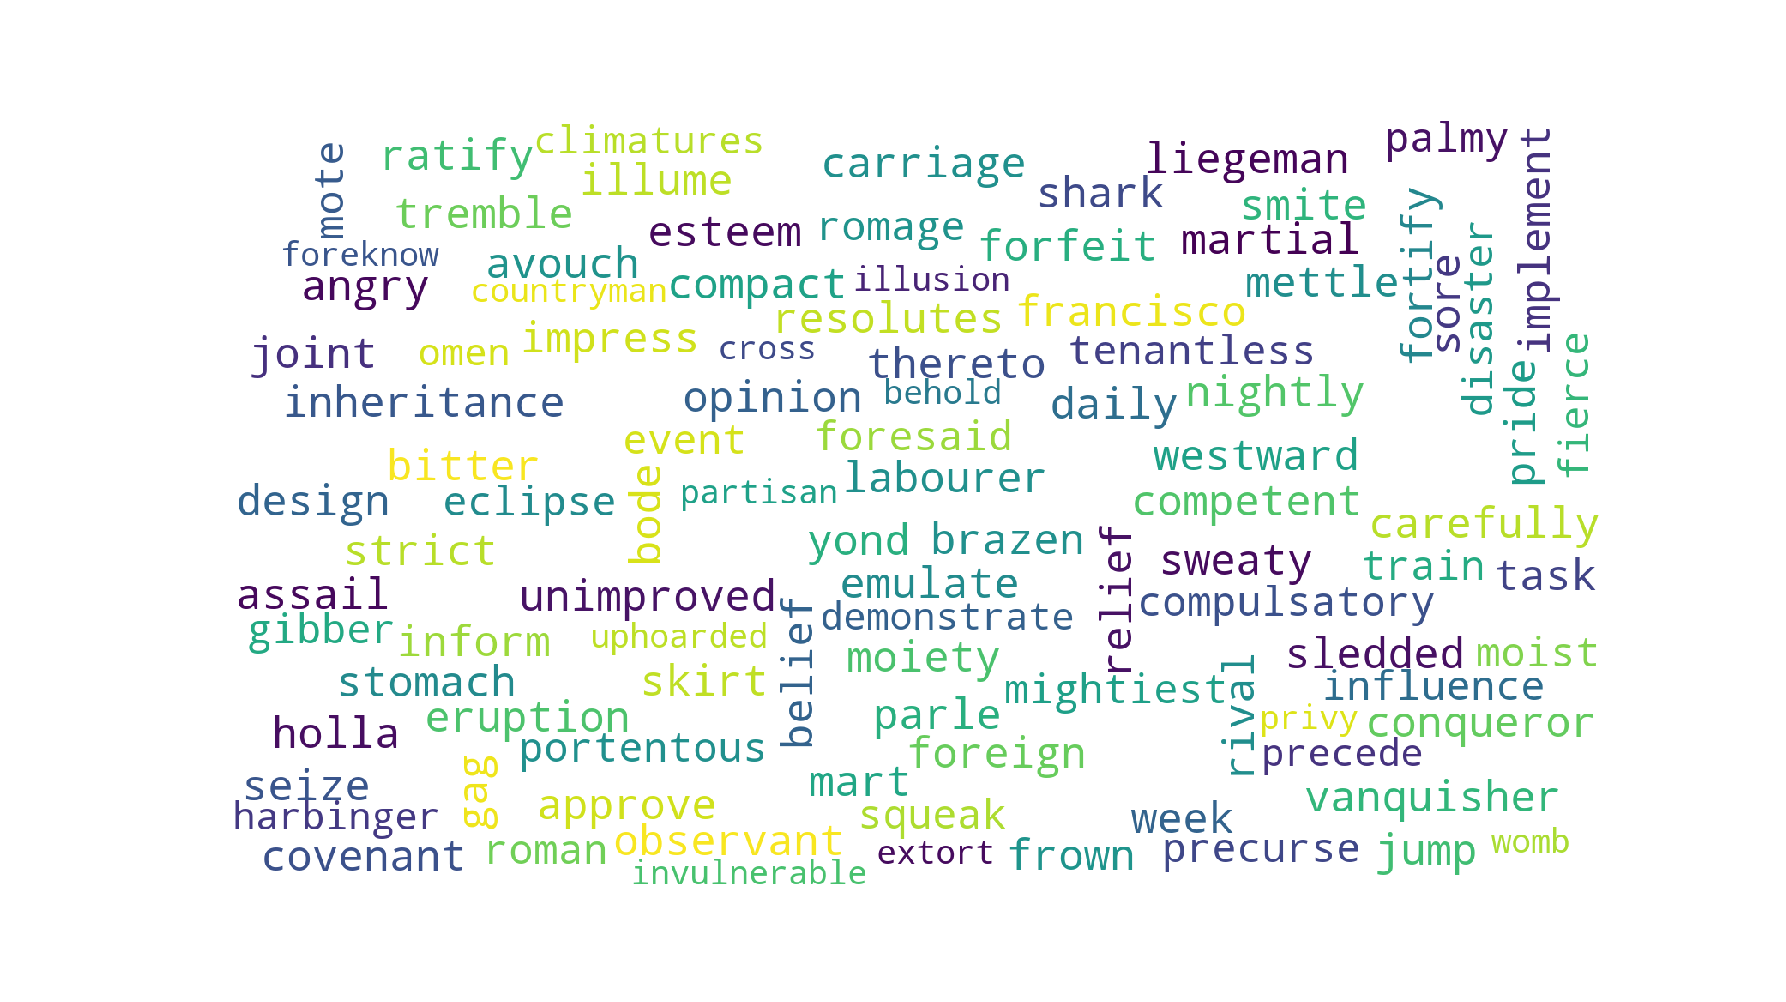

In [18]:
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#plt.savefig('wordcloud_unusual_words')

## Challenge 3: Compute the sentiment score for each scene.

**How do we do sentiments analysis?**

1. Start from scrach:
    
    1.1 Label your dataset (or any related open source corpus)
    
    1.2 Word embeddings
        GLove (bag of words)
        ELMo, BERT (deep learning)
    
    1.3 Train your own model
        From logistice regression to LSTM, or even try state-of-art deep learning models (e.g. BERT)

2. Pre-trained model
    
    2.1 Commercial sentiment analysis API
        Leading company like DeepAI and Google, has their pretrained models host on cloud. 
        They provide REST API to allow user to request the server
        
    2.2 Research purpose
        Here I use AllenNLP, we can easily prototype the model & develop customized models
        
**Reference:**

   - [DeepAI - sentiment analysis](https://deepai.org/machine-learning-model/sentiment-analysis)
    
   - [Google - analyzing_sentiment](https://cloud.google.com/natural-language/docs/analyzing-sentiment)

   - [AllenNLP - demo: sentiment analysis](https://demo.allennlp.org/sentiment-analysis)

In [19]:
from allennlp.predictors.predictor import Predictor
predictor = Predictor.from_path(
        "https://s3-us-west-2.amazonaws.com/allennlp/models/sst-2-basic-classifier-glove-2019.06.27.tar.gz"
        )

# 1 -> positive
# 0 -> negative

In [20]:
# A simple example to present how to use allennlp
predictor.predict(
  sentence= 'Live long and prosper'
)

{'logits': [0.8459727168083191, -0.7954796552658081],
 'probs': [0.8377324342727661, 0.1622675359249115],
 'label': '1'}

In [21]:
# concatenate all lines within one scene to get the sentiment score 
sst_ana_score = {}
for whichScene,lines in playScript.items():
    tmp_corpus = ''
    for line in lines:
        tmp_corpus += line[1]
    if tmp_corpus == '':
        continue
    score = predictor.predict(sentence = tmp_corpus)['probs'][0]
    sst_ana_score[whichScene] = score

# Take a look at the sentiment score for Act I Scene I
sst_ana_score['ACT I','SCENE I']

0.4726696014404297

<IPython.core.display.Javascript object>


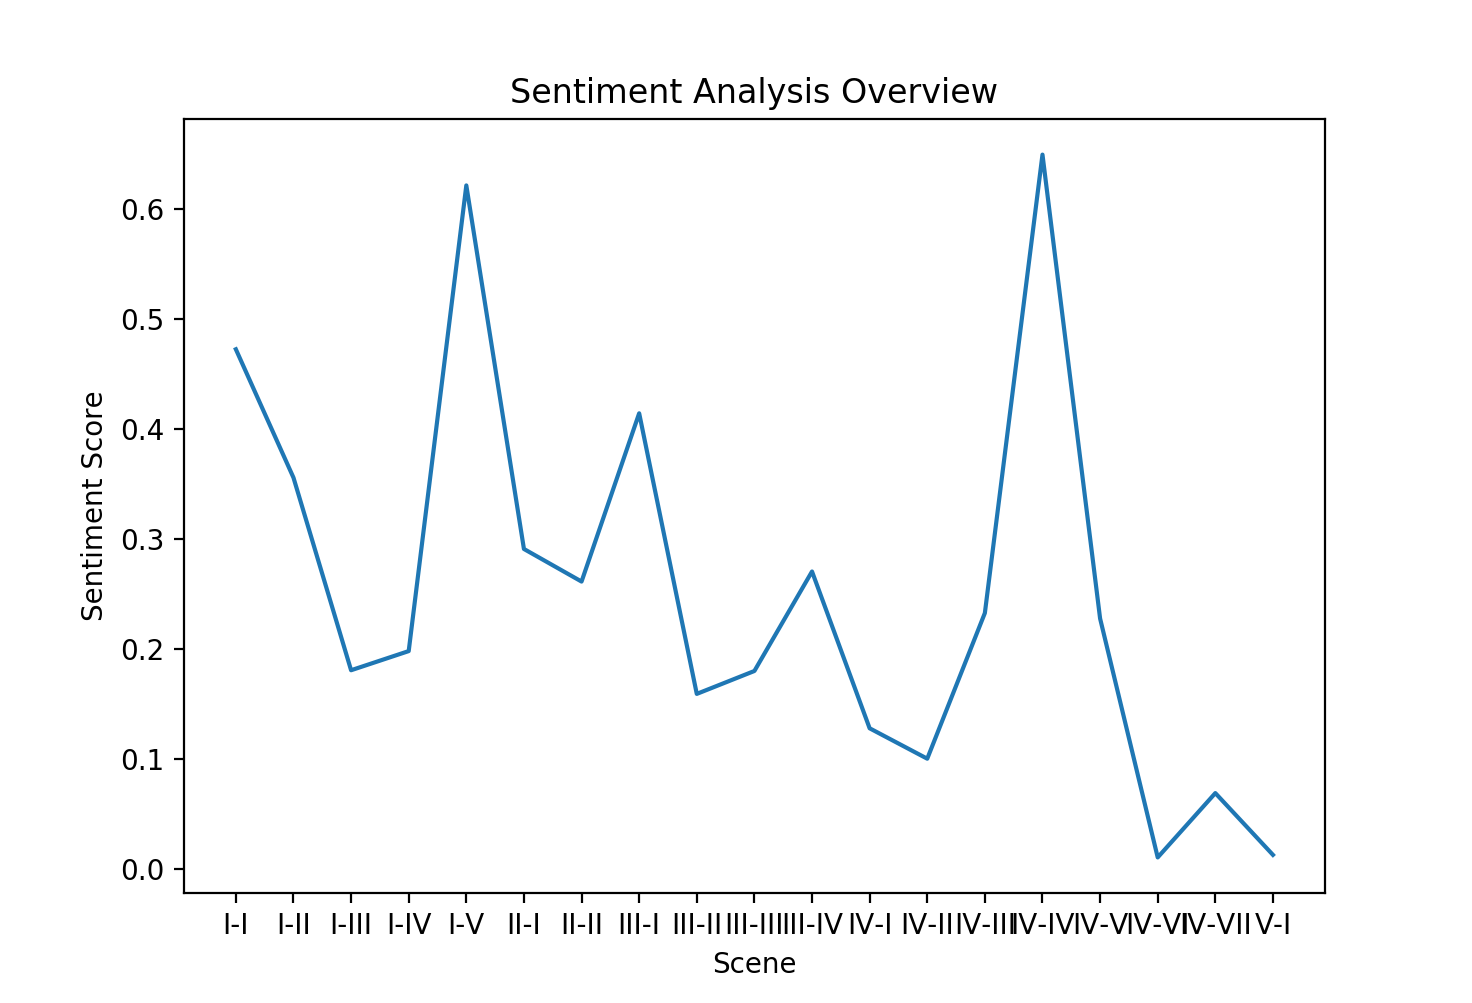

In [22]:
x_axis = [ str(x.split(' ')[-1])+'-'+str(y.split(' ')[-1]) for x,y in list(sst_ana_score.keys())]
fig = plt.figure(2)
plt.plot(x_axis,list(sst_ana_score.values()))
plt.xlabel('Scene')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis Overview')
plt.show()


In [23]:
# if we are only interested in one character, see how he changes during the play
sst_ana_char = {}
whichChar = 'HAMLET'
for whichScene,lines in playScript.items():
    tmp_corpus = ''
    for line in lines:
        if line[0] == whichChar:
            tmp_corpus += line[1] + ' '
    if tmp_corpus == '':
        continue
    sst_ana_char[whichScene] = predictor.predict(sentence = line[1])['probs'][0]

<IPython.core.display.Javascript object>


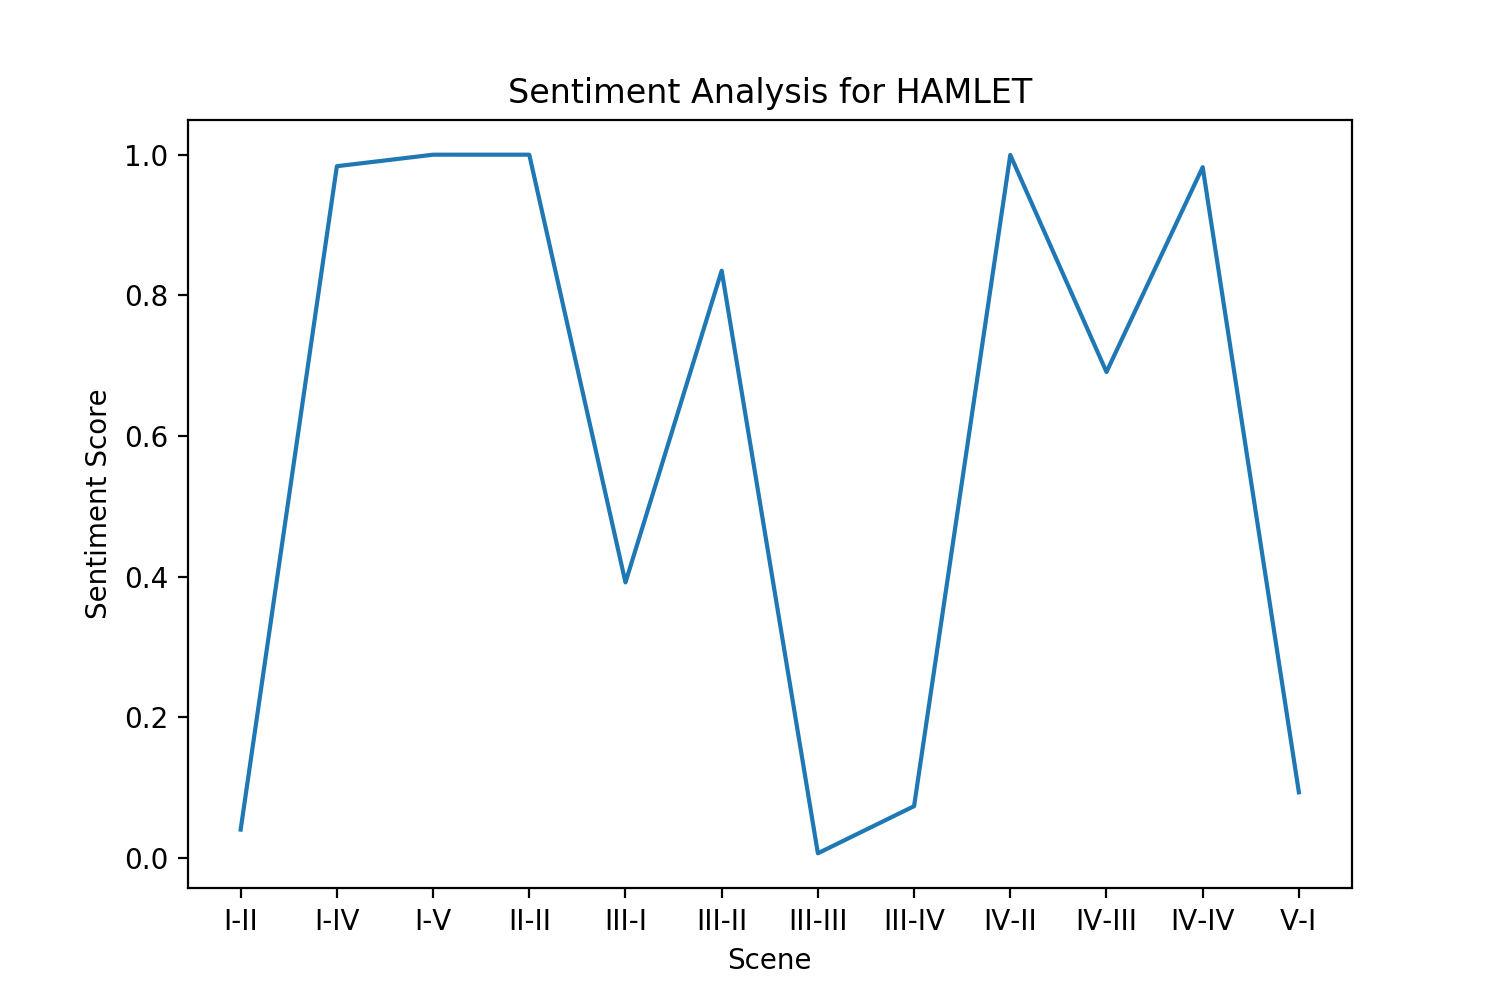

In [25]:
x_axis_char = [ str(x.split(' ')[-1])+'-'+str(y.split(' ')[-1]) for x,y in list(sst_ana_char.keys())]
fig = plt.figure(3)
plt.plot(x_axis_char,list(sst_ana_char.values()))
plt.xlabel('Scene')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis for '+whichChar)
plt.show()